# Introduction

In this tutorial, we will learn how to implement different policies and temporal difference learning algorithms, as well as a hybrid (model building) algorithm, then compare their performance to the dynamic programming algorithms we implemented in the first tutorial.

# Notebook setup

## Instructions

- Import numpy, scipy and matplotlib
- Configure inline plots

In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

# Tutorial

## Learning algorithms and policies

__Learning algorithms__:

*Sarsa (on-policy)*

\begin{align}
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big(r_{t+1} + \gamma Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)\big)
\end{align}

with temporal discount rate $\gamma$ and learning rate $\alpha$.

*Q-learning (off-policy)*

\begin{align}
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big(r_{t+1} + \gamma\max_\limits{a} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)\big)
\end{align}


__Policies__:

*Epsilon-greedy*

\begin{align}
P(a_t|s_t) = \epsilon \frac{1}{N_a}  + (1-\epsilon)1[a_t =\max_\limits{a}Q(a_t,s_t)]
\end{align}

*Softmax*

\begin{align}
P(a_t|s_t) = \frac{\exp(Q(a_t,s_t)/\tau)}{\Sigma_{i=1}^n \exp(Q(i)/\tau)}
\end{align}

Please familiarize yourself with the code below, as it will help your write your own code to solve the exercises.

In [2]:
# Import definitions of the environments.
import RL_worlds as worlds

# Import helper functions for plotting.
from plot_util import *

In [24]:
def init_state(params):
    """
    Initialize the state at the beginning of an episode.
    Args:
        params: a dictionary containing the default parameters.
    Returns:
        an integer corresponding to the initial state.
    """
    if params['environment'].name == 'windy_cliff_grid':
        return 0
    elif params['environment'].name == 'n_armed_bandit':
        return 0
    elif params['environment'].name == 'cheese_world':
        return 0
    elif params['environment'].name == 'cliff_world':
        return 0
    elif params['environment'].name == 'quentins_world':
        return 54

def update_state(state, action, params):
    """
    State transition based on world, action and current state.
    Args:
        state: integer corresponding to the current state.
        action: integer corresponding to the action taken.
        params: a dictionary containing the default parameters.
    Returns:
        an integer corresponding to the next state;
        an integer corresponding to the reward received.
    """
    next_state, reward = params['environment'].get_outcome(state, action)
    return next_state, reward
    
def call_policy(state, value, params):
    """
    Call a policy to choose actions, given current state and value function.
    Args:
        state: integer corresponding to the current state.
        value: a matrix indexed by state and action.
        params: a dictionary containing the default parameters.
    Returns:
        an integer corresponding action chosen according to the policy.
    """
    # multiple options for policy
    if params['policy'] == 'epsilon_greedy':
        return epsilon_greedy(state, value, params)
    elif params['policy'] == 'softmax':
        return softmax(state, value, params)
    else: # random policy (if policy not recognized, choose randomly)
        return randint(params['environment'].n_actions)

def update_value(prev_state, action, reward, state, value, params):
    """
    Update the value function.
    Args:
        prev_state: an integer corresponding to the previous state.
        action: an integer correspoding to action taken.
        reward: a float corresponding to the reward received.
        state: an integer corresponding to the current state;
          should be None if the episode ended.
        value: a matrix indexed by state and action.
        params: a dictionary containing the default parameters. 
    Returns:
        the updated value function (matrix indexed by state and action).
    """
    if params['learning_rule'] == 'q_learning':
        # off policy learning
        return q_learning(prev_state, action, reward, state, value, params)
    elif params['learning_rule'] == 'sarsa':
        # on policy learning
        return sarsa(prev_state, action, reward, state, value, params)
    else:
        print('Learning rule not recognized')

def default_params(environment):
    """
    Define the default parameters.
    Args:
        environment: an object corresponding to the environment.
    Returns:
        a dictionary containing the default parameters, where the keys
            are strings (parameter names).
    """
    params = dict()
    params['environment'] = environment
    
    params['alpha'] = 0.1  # learning rate    
    params['beta'] = 10  # inverse temperature    
    params['policy'] = 'epsilon_greedy'
    params['epsilon'] = 0.05  # epsilon-greedy policy
    params['learning_rule'] = 'q_learning'
    params['epsilon_decay'] = 0.9
    
    if environment.name == 'windy_cliff_grid':
        params['gamma'] = 0.6  # temporal discount factor
    elif environment.name == 'n_armed_bandit':
        params['gamma'] = 0.9  # temporal discount factor
    elif environment.name == 'cliff_world':
        params['gamma'] = 1.0  # no discounting
    elif environment.name == 'cheese_world':
        params['gamma'] = 0.5  # temporal discount factor
    elif environment.name == 'quentins_world':
        params['gamma'] = 0.9  # temporal discount factor

    return params

## Exercise 1: Decision Policies

1. Write an epsilon-greedy policy function.

2. Write a softmax policy function.

Tip: both functions should take the current state, the value function and default parameters as input and return an action.

In [25]:
def epsilon_greedy(state, value, params):
    if np.random.rand() < 1 - params["epsilon"]: 
        a = argmax(value[state, :])
    else:
        a = np.random.randint(params["environment"].n_actions)
    return a

In [26]:
def soft_max(state, value, params):
    p = np.exp(value[state, :] * params["beta"])
    p = p / sum(p)
    np.random.choice(range(params["environment"].n_actions), p = p)

## Exercise 2: Learning Algorithms

1. Write a Q-learning (off-policy) algorithm.
2. Modify your Q-learning algorithm to obtain a Sarsa (on-policy) algorithm.

Tip: both functions should take the previous state, action taken, reward received, value function, current state and default parameters and return the updated value function.

In [62]:
def q_learning(state, action, reward, next_state, value, params):
    max_value = max(value[next_state,:]) if next_state is not None else 0
    delta = reward + params["gamma"] * max_value - value[state, action]
    value[state, action] += params["alpha"] * delta
    return value

In [37]:
def sarsa(state, action, reward, next_state, value, params):
    next_action =  call_policy(next_state, value, params)
    next_value = value[next_state, next_action] if next_state != None else 0
    delta = reward + params["gamma"] * next_value - value[state, action]
    value[state, action] += params["alpha"] * delta
    return value

## Exercise 3

1. Write code that allows you to select a world, a learning algorithm and a decision policy. Run 500 episodes (visits to the world) with learning across episodes. Make sure to set a maximum number of steps per episode (e.g. 1000). Use the functions provided in the plot_util module to:
    - Plot the value associated with each action at each state;
    - Plot the action corresponding to the maximum value at each state;
    - Plot the maximum value in each state;
    - Plot the total reward obtained in each episode.
2. Experiment with different values for the parameters:
    - Pick a range for the learning rate $\alpha$ and look at how the results change.
    - Pick a range for the inverse temperature $\beta$ (using a softmax policy) and look at how the results change.
    - Pick a range for $\epsilon$ (using an $\epsilon$-greedy policy) and look at how the results change.
    - Pick a range for the temporal discount factor $\gamma$ and look at how the results change.
3. Explore the cliff world with an $\epsilon$-greedy policy (try $\epsilon$=0.1) comparing the performance of Q-learning (off-policy) and Sarsa (on-policy). What differences do you notice? What do these differences tell us about on- and off-policy learning?
4. Compare your results using Q-learning and Sarsa with those obtained in the previous tutorial. What do you notice about the differences in performance between dynamic programming and TD learning algorithms? What are some of the advantages and disadvantages of each approach?

To make sure that your algorithms have been implemented correctly, compare your results to the ones shown below.

Cliff world using Q-learning and an $\epsilon$-greedy policy with $\epsilon$=0.1 and $\alpha$=0.3:

<img src="fig/tutorial2_ex3_qlearning_values.png",height="300",width="300",align="left">
<img src="fig/tutorial2_ex3_qlearning_actions.png",height="300",width="300">
<img src="fig/tutorial2_ex3_qlearning_maxval.png",height="300",width="300",align="left">
<img src="fig/tutorial2_ex3_qlearning_rewards.png",height="300",width="300">

Quentin's world using Sarsa and a softmax policy with $\beta$=10 and $\alpha$=0.4:

<img src="fig/tutorial2_ex3_sarsa_values.png",height="300",width="300",align="left">
<img src="fig/tutorial2_ex3_sarsa_actions.png",height="300",width="300">
<img src="fig/tutorial2_ex3_sarsa_maxval.png",height="300",width="300",align="left">
<img src="fig/tutorial2_ex3_sarsa_rewards.png",height="300",width="300">

In [38]:
def RL(params, n_episodes = 500, n_steps = 1000):
    env = params["environment"]
    value = np.zeros((env.n_states, env.n_actions))
    rewards = []
    for episode in range(n_episodes):
        state = init_state(params)
        reward_sum = 0
        for step in range(n_steps):
            action = call_policy(state, value, params)
            next_state, reward = update_state(state, action, params)
            reward_sum += reward
            value = update_value(state, action, reward, next_state, value, params)  
            state = next_state
            if next_state == None: break
        rewards.append(reward_sum)
    return value, rewards

In [39]:
def plot_RL(params, value, rewards):
    plot_state_action_values(params["environment"], value)
    plot_quiver_max_action(params["environment"], value)
    plot_heatmap_max_val(params["environment"], value)
    plot_rewards(len(rewards), rewards)
    plt.show()

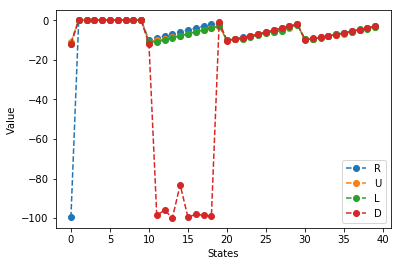

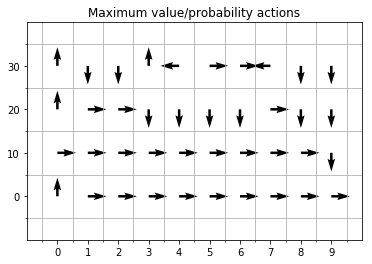

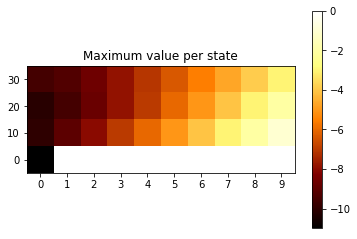

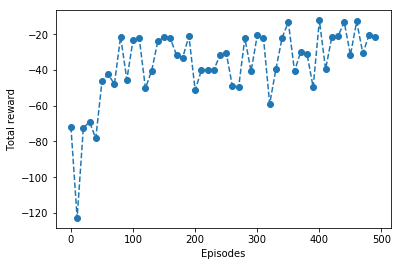

In [40]:
params = default_params(worlds.cliff_world())
params["epsilon"] = 0.1
params["alpha"] = 0.3
params["policy"] = "epsilon_greedy"
params["learning_rule"] = "q_learning"
value, rewards = RL(params)
plot_RL(params, value, rewards)

## Exercise 4: Dyna-Q

1. Implement the Dyna-Q algorithm for a deterministic environment.

Tip: the function should take the default parameters, an integer k for the number random updates, and a threshold for the stopping criterium as input and return a value function and deterministic model of the environment.

In [63]:
def update(params, value, state, action):
    next_state, reward = update_state(state, action, params)
    value = update_value(state, action, reward, next_state, value, params)
    return value

In [64]:
def dyna_q(params, value, model, K = 100, N = 1000):
    env = params["environment"]
    state = np.random.randint(env.n_states)
    for n in range(N):
        action = call_policy(state, value, params)
        next_state, reward = update_state(state, action, params)
        value = update_value(state, action, reward, next_state, value, params)  
        model[(state, action)] = (next_state, reward)
        for k in range(K):
            state, action = model.keys()[np.random.randint(len(model.keys()))]
            value = update(params, value, state, action)          
        state = next_state if next_state is not None else np.random.randint(env.n_states)
    return value, model

## Exercise 5

1. Write code that allows you to test the performance of Dyna-Q for a selected world and a selected learning rule. Run 500 episodes (visits to the world) with learning across episodes. Make sure to set a maximum number of steps per episode (e.g. 1000). Use the functions provided in the plot_util module to:
    - Plot the value associated with each action at each state;
    - Plot the action corresponding to the maximum value at each state;
    - Plot the maximum value in each state;
    - Plot the total reward obtained in each episode.
2. Experiment with different values for the parameters:
    - Pick a range for the learning rate $\alpha$ and look at how the results change.
    - Pick a range for the temporal discount factor $\gamma$ and look at how the results change.
    - Pick a range for k (number of random updates performed in Dyna-Q) and look at how the results change.
3. Compare these results with those obtained for dynamic programming in the previous tutorial, as well as the TD algorithms from this tutorial.

To make sure that your algorithm has been implemented correctly, compare your results to the ones shown below.

Windy cliff grid using Dyna-Q and an $\epsilon$-greedy policy with $\epsilon$=0.05, $\alpha$=0.5 and $\gamma$=0.8:

<img src="fig/tutorial2_ex5_dynaq_values.png",height="300",width="300",align="left">
<img src="fig/tutorial2_ex5_dynaq_actions.png",height="300",width="300">
<img src="fig/tutorial2_ex5_dynaq_maxval.png",height="300",width="300",align="left">
<img src="fig/tutorial2_ex5_dynaq_rewards.png",height="300",width="300">


In [1]:
def Dyna(params, n_episodes = 500, n_steps = 1000, K = 100, N = 1000):
    env = params["environment"]
    value = np.zeros((env.n_states, env.n_actions))
    model = {}
    rewards = []
    for episode in range(n_episodes):
        state = init_state(params)
        reward_sum = 0
        value, model = dyna_q(params, value, model, K = K, N = N)
        for step in range(n_steps):
            action = call_policy(state, value, params)
            next_state, reward = update_state(state, action, params)
            reward_sum += reward
            value = update_value(state, action, reward, next_state, value, params)  
            state = next_state
            if next_state is None: break
        rewards.append(reward_sum)
    return value, rewards

In [2]:
params = default_params(worlds.windy_cliff_grid())
params["epsilon"] = 0.05
params["alpha"] = 0.5
params["gamma"] = 0.8
params["policy"] = "epsilon_greedy"
params["learning_rule"] = "q_learning"
value, rewards = Dyna(params)
plot_RL(params, value, rewards)

NameError: name 'default_params' is not defined

## Exercise 6
1. We will now compare Q-learning and Dyna-Q to see how each of these algorithms responds to a change in the structure of the environment. We will use a modified version of the windy cliff grid, windy_cliff_grid_2, which is the same as the original except for the location of the doors leading to the two windy rooms.

    - For each algorithm, run 500 episodes in the original world. Then, switch to the modified world and run 500 more episodes.
    - You can use an $\epsilon$-greedy policy with $\epsilon$=0.05 throughout.
    - After both sets of episodes, plot the value of each action at each state, the action of maximum value at each state, the maximum value at each state and the total reward obtained in each episode (plot the accumulated rewards only for the 500 episodes in the modified world).
    - What do you notice about the difference in each algorithm's performance once the environment has changed?